In [35]:
import pandas as pd
import numpy as np
import math
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from multiprocessing import Pool
seed = 42

In [52]:
with Pool(50) as p:
    samples = pd.concat(p.map(pd.read_csv, glob.glob('./outputs/ibm/*.csv')))
samples = samples.reset_index(drop=True)

In [53]:
samples = samples.drop(samples[samples.EIR == -1].index).reset_index(drop=True)

In [54]:
output_columns = [f'prev_{i}' for i in range(1, 366)]
outputs = samples[output_columns]
#months = [p.month for p in (pd.Period('2000-01-01') + np.arange(365))]
#outputs = outputs.groupby(by=months, axis=1).mean()
features = samples.drop(labels=output_columns + ['init_EIR'], axis=1)
n_features = len(features.columns)
n_outputs = len(outputs.columns)

In [55]:
idx_train, idx_test = train_test_split(
    np.arange(len(outputs)), #np.arange(100000),
    test_size=0.2,
    random_state=seed
)

In [56]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers, Model

In [57]:
X_train = features.iloc[idx_train]
y_train = outputs.iloc[idx_train].to_numpy()[:, :, np.newaxis]
X_test = features.iloc[idx_test]
y_test = outputs.iloc[idx_test].to_numpy()[:, :, np.newaxis]

scaler = layers.Normalization()
scaler.adapt(X_train.to_numpy())

In [58]:
y_train.shape

(80000, 365, 1)

In [59]:
def create_sequence_model(
    optimiser='adam',
    n_hidden=2,
    units=128,
    dropout=0.,
    loss='log_cosh',
    hidden_activation='relu',
    hidden_initialiser='he_normal',
    output_activation='linear',
    output_initialiser='glorot_normal',
    output_units=y_train.shape[2],
    output_time=y_train.shape[1]
):
    input_layer = layers.Input(shape=(n_features,), dtype='float32')
    input_encoding = scaler(input_layer)
    for i in range(n_hidden):
        input_encoding = layers.Dense(
            units,
            activation=hidden_activation,
            kernel_initializer=hidden_initialiser
        )(input_encoding)
        input_encoding = layers.Dropout(dropout)(input_encoding)
    output = tf.repeat(input_encoding[:, tf.newaxis, :], output_time, 1)
    for i in range(n_hidden):
        output = layers.LSTM(units, return_sequences=True)(output)
    output = layers.TimeDistributed(layers.Dense(output_units, activation=output_activation, kernel_initializer=output_initialiser))(output)
    model = Model(inputs = [input_layer], outputs = [output])
    model.compile(loss=loss, optimizer=optimiser, metrics='mse')
    return model

In [60]:
model = create_sequence_model()
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 31)]              0         
                                                                 
 normalization_3 (Normalizat  (None, 31)               63        
 ion)                                                            
                                                                 
 dense_9 (Dense)             (None, 128)               4096      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                           

In [61]:
model.fit(X_train, y_train, batch_size=100, epochs=100)

Epoch 1/100
800/800 [==============================] - 32s 37ms/step - loss: 0.0050 - mse: 0.0101
Epoch 2/100
800/800 [==============================] - 29s 37ms/step - loss: 0.0033 - mse: 0.0066
Epoch 3/100
800/800 [==============================] - 29s 36ms/step - loss: 0.0026 - mse: 0.0052
Epoch 4/100
800/800 [==============================] - 29s 37ms/step - loss: 0.0018 - mse: 0.0036
Epoch 5/100
800/800 [==============================] - 29s 36ms/step - loss: 0.0012 - mse: 0.0024
Epoch 6/100
800/800 [==============================] - 30s 37ms/step - loss: 9.2320e-04 - mse: 0.0019
Epoch 7/100
800/800 [==============================] - 29s 37ms/step - loss: 7.0745e-04 - mse: 0.0014
Epoch 8/100
800/800 [==============================] - 29s 37ms/step - loss: 5.6350e-04 - mse: 0.0011
Epoch 9/100
800/800 [==============================] - 30s 37ms/step - loss: 4.5260e-04 - mse: 9.0635e-04
Epoch 10/100
800/800 [==============================] - 30s 37ms/step - loss: 4.0016e-04 - mse: 8.

In [62]:
y_hat = model.predict(X_test)

625/625 [==============================] - 10s 15ms/step


Text(0, 0.5, 'true')

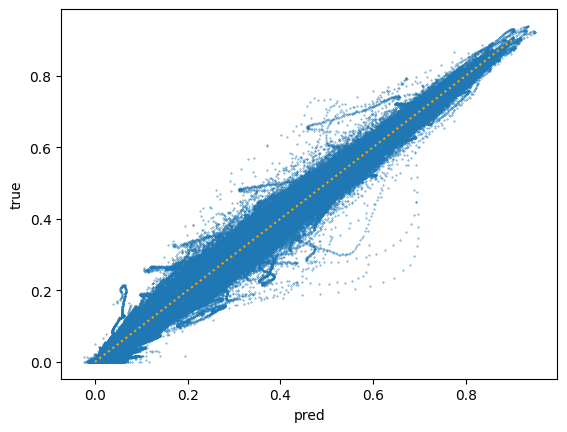

In [63]:
plt.scatter(y_hat.flatten(), y_test.flatten(), s=0.1)
plt.plot(np.linspace(0, 0.9), np.linspace(0, 0.9), linestyle=':', color='orange')
plt.xlabel('pred')
plt.ylabel('true')

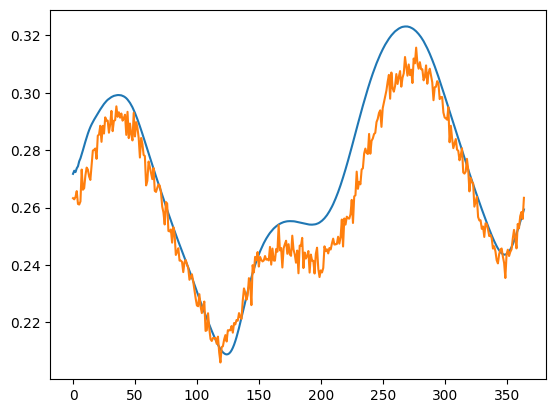

In [64]:
i = 10
plt.plot(range(365), y_hat[i,:,0])
plt.plot(range(365), y_test[i,:,0])

Text(0, 0.5, 'true')

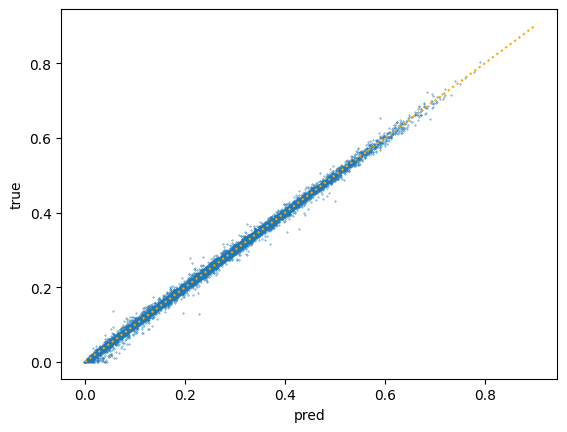

In [65]:
plt.scatter(np.mean(y_hat, axis=1), np.mean(y_test, axis=1), s=0.1)
plt.plot(np.linspace(0, 0.9), np.linspace(0, 0.9), linestyle=':', color='orange')
plt.xlabel('pred')
plt.ylabel('true')

In [12]:
import keras_tuner as kt

In [13]:
def bulid_hypermodel(hp):
    return create_model(
        n_hidden = hp.Int("n_hidden", min_value=1, max_value=5, step=1),
        units = hp.Int("units", min_value=32, max_value=512, step=32),
        dropout = hp.Float("dropout", min_value=0., max_value=.2, step=.01),
        loss = hp.Choice("loss", ['mse', 'log_cosh']),
        hidden_activation = hp.Choice("hidden_activation", ['relu', 'elu']),
        output_activation = hp.Choice("output_activation", ['linear', 'softmax'])
    )

In [14]:
tuner = kt.Hyperband(
    hypermodel=bulid_hypermodel,
    objective="val_mse",
    max_epochs=100,
    seed=42,
    overwrite=True,
    directory="hyperparameters",
    project_name="det",
)

In [15]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
n_hidden (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.2, 'step': 0.01, 'sampling': None}
loss (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mse', 'log_cosh'], 'ordered': False}
hidden_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], 'ordered': False}
output_activation (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'softmax'], 'ordered': False}


In [16]:
X_hyp_train, X_hyp_val, y_hyp_train, y_hyp_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=seed
)

In [17]:
tuner.search(
    X_hyp_train,
    y_hyp_train,
    validation_data=(X_hyp_val, y_hyp_val),
    callbacks=[tf.keras.callbacks.EarlyStopping("mse", min_delta=1e-10, patience=5)]
)

Trial 230 Complete [00h 02m 17s]
val_mse: 0.00022005359642207623

Best val_mse So Far: 9.33476330828853e-05
Total elapsed time: 02h 25m 44s

Search: Running Trial #231

Value             |Best Value So Far |Hyperparameter
4                 |4                 |n_hidden
192               |96                |units
0.02              |0                 |dropout
mse               |mse               |loss
elu               |elu               |hidden_activation
linear            |linear            |output_activation
34                |100               |tuner/epochs
12                |34                |tuner/initial_epoch
2                 |4                 |tuner/bracket
1                 |4                 |tuner/round
0225              |0144              |tuner/trial_id

Epoch 13/34
2000/2000 [==============================] - 7s 3ms/step - loss: 0.0174 - mse: 0.0174 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 14/34
2000/2000 [==============================] - 7s 3ms/step - loss: 0.0023 - 

KeyboardInterrupt: 

623/623 [==============================] - 1s 1ms/step


Text(0, 0.5, 'true')

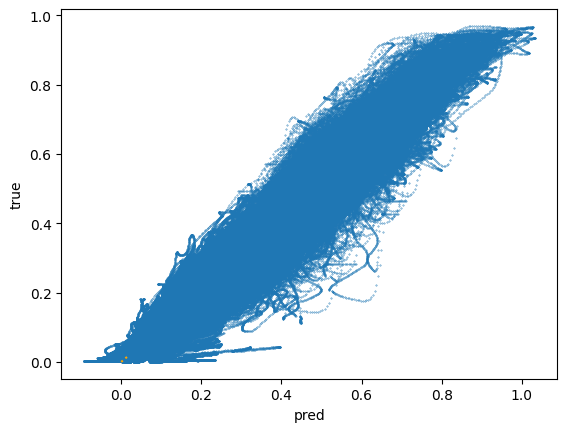

In [38]:
bm = tuner.get_best_models(num_models=1)[0]
y_hat = model.predict(X_test)
plt.scatter(y_hat.flatten(), y_test.to_numpy().flatten(), s=0.1)
plt.plot(np.linspace(0, 0.02), np.linspace(0, 0.02), linestyle=':', color='orange')
plt.xlabel('pred')
plt.ylabel('true')

In [39]:
tuner.results_summary()

Results summary
Results in hyperparameters/eq
Showing 10 best trials
Trial summary
Hyperparameters:
n_hidden: 4
units: 128
dropout: 0.09
loss: log_cosh
hidden_activation: elu
output_activation: linear
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0143
Score: 0.0011498170206323266
Trial summary
Hyperparameters:
n_hidden: 3
units: 96
dropout: 0.07
loss: log_cosh
hidden_activation: elu
output_activation: linear
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0238
Score: 0.0012141329934820533
Trial summary
Hyperparameters:
n_hidden: 3
units: 192
dropout: 0.04
loss: mse
hidden_activation: relu
output_activation: linear
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0219
Score: 0.0015096659772098064
Trial summary
Hyperparameters:
n_hidden: 3
units: 96
dropout: 0.09
loss: log_cosh
hidden_activation: elu
output_activation: linear
tuner/epochs: 100
tuner/initial_epoch:

In [30]:
model.save('models/det_sequence')

INFO:tensorflow:Assets written to: models/det_sequence/assets


INFO:tensorflow:Assets written to: models/det_sequence/assets
